# **Project: Amazon Product Recommendation System**

# **Navbakhor Berdieva**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [5]:
#Google Colab only
# from google.colab import drive
# drive.mount('/content/drive')

**Installing surprise library**

In [6]:
# !pip install surprise  =  first you must instal these libraries (however it works only google colab)

In [7]:
# !pip install -U seaborn = u can run this code in your local machine vs code but it requires SKD

## **Importing the necessary libraries and overview of the dataset**

In [8]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [9]:
# Import the dataset and give the column names
columns=['user_id', 'prod_id', 'ratings','timestamp']


In [10]:
#Reading the Input CSV from the Drive
orig_df = pd.read_csv('data.csv' , names =columns)

In [11]:
#Checking the Data size
orig_df.shape

(1055795, 4)

There are 78K records and 4 columns in our input dataset.

In [12]:
orig_df.head()

,user_id,prod_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1.365811e+09
1,A2CX7LUOHB2NDG,0321732944,5.0,1.341101e+09
2,A2NWSAGRHCP8N5,0439886341,1.0,1.367194e+09
3,A2WNBOD3WNDNKT,0439886341,3.0,1.374451e+09
4,A1GI0U4ZRJA8WN,0439886341,1.0,1.334707e+09


In [13]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055795 entries, 0 to 1055794
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1055795 non-null  object 
 1   prod_id    1055795 non-null  object 
 2   ratings    1055794 non-null  float64
 3   timestamp  1055794 non-null  float64
dtypes: float64(2), object(2)
memory usage: 32.2+ MB


Removing Timestamp column

In [14]:
orig_df = orig_df.drop('timestamp', axis = 1)

In [15]:
orig_df.shape

(1055795, 3)

In [16]:
df = orig_df

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [17]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [18]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [19]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [20]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [21]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,ratings
40261,ALUNVOQRXOZIA,B00004SB92,1.0
40361,A1JWSDDIH5Z7DV,B00004SB92,5.0
40411,A5JLAU2ARJ0BO,B00004SB92,4.0
40702,A1RPTVW5VEOSI,B00004SB92,5.0
40823,A231WM2Z2JL0U3,B00004SB92,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [22]:
df_final.shape

(37, 3)

### **Check the number of rows and columns and provide observations.**

In [23]:
# Check the number of rows and columns and provide observations
df_final.describe


<bound method NDFrame.describe of                user_id     prod_id  ratings
40261    ALUNVOQRXOZIA  B00004SB92      1.0
40361   A1JWSDDIH5Z7DV  B00004SB92      5.0
40411    A5JLAU2ARJ0BO  B00004SB92      4.0
40702    A1RPTVW5VEOSI  B00004SB92      5.0
40823   A231WM2Z2JL0U3  B00004SB92      5.0
40905   A2B7BUH8834Y6M  B00004SB92      4.0
40990   A1F9Z42CFF9IAY  B00004SB92      4.0
72435   A3OXHLG6DIBRW8  B00004ZCJE      5.0
73533   A1MJMYLRTZ76ZX  B00004ZCJE      5.0
73741    A1VQHH85U7PX0  B00004ZCJE      5.0
74049   A2XRMQA6PJ5ZJ8  B00004ZCJE      3.0
74170   A2B7BUH8834Y6M  B00004ZCJE      5.0
102099  A15QYHQH80W30L  B00005LEN4      5.0
102147   A5JLAU2ARJ0BO  B00005LEN4      5.0
102305   AKT8TGIT6VVZ5  B00005LEN4      5.0
102386  A1FR68QH6Z4YZM  B00005LEN4      4.0
102541  A250AXLRBVYKB4  B00005LEN4      5.0
230870  A25HBO5V8S8SEA  B00007KDVI      2.0
231157   AT6CZDCP4TRGA  B00007KDVI      1.0
231747   AWPODHOB4GFWL  B00007KDVI      3.0
231760  A149RNR5RH19YY  B00007KDVI      4.0
232040  A231WM2Z2JL0U3  B00007KDVI      5.0
251588   A5JLAU2ARJ0BO  B00008OE6I      5.0
251620   ABH9D1TEOJ56E  B00008OE6I      5.0
251713  A231WM2Z2JL0U3  B00008OE6I      4.0
251726  A12DLJESJKM1OQ  B00008OE6I      5.0
251773  A1F9Z42CFF9IAY  B00008OE6I      4.0
680951   A5JLAU2ARJ0BO  B0009RKL5S      1.0
681016  A1MJMYLRTZ76ZX  B0009RKL5S      2.0
681025  A2R6RA8FRBS608  B0009RKL5S      4.0
681044  A1ODOGXEYECQQ8  B0009RKL5S      5.0
681110  A1F9Z42CFF9IAY  B0009RKL5S      1.0
755453   A5JLAU2ARJ0BO  B000BKJZ9Q      2.0
756192  A1FR68QH6Z4YZM  B000BKJZ9Q      4.0
756378  A1MJMYLRTZ76ZX  B000BKJZ9Q      5.0
756647   A1VQHH85U7PX0  B000BKJZ9Q      5.0
757132    A6FIAB28IS79  B000BKJZ9Q      5.0>

**Observations**

From the original dataset we have converted the new dataset into 65290 rows which includes users with min 50 ratings.

### **Data types**

In [24]:
# Check Data types and provide observations

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 40261 to 757132
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  37 non-null     object 
 1   prod_id  37 non-null     object 
 2   ratings  37 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.2+ KB


**Observations**

All data types are Object data types & all contains non-null values.

### **Checking for missing values**

In [25]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
ratings,0


**Observations**
There are no missing data i.e. null values.

### **Summary Statistics**

In [26]:
# Summary statistics of 'rating' variable and provide observations
df_final['ratings'].describe()


,ratings
count,37.000000
mean,3.972973
std,1.384166
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Observations**

1. ADLVFFE4VBT8 is the top user_id with more number of user ratings i.e. 295 times.
2. B0088CJT4U is the top product that have been reviewed by most users ie. 206 times.
3. Raing 5.0 is been more popular rating across different users, more than 75% of the data contains top rating as 5.0. That means users are more satisfied with the products and giving postive ratings.   


### **Checking the rating distribution**

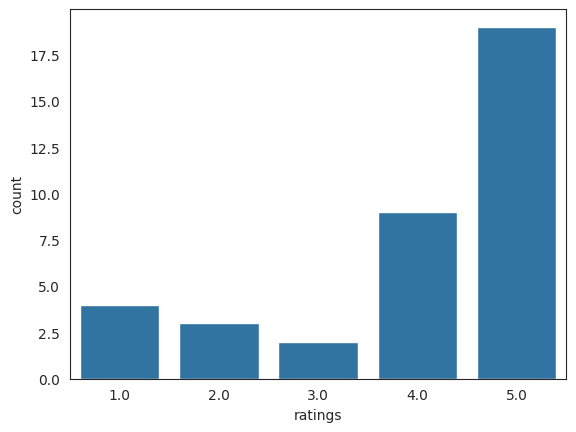

In [27]:
# Create the bar plot and provide observations
with sns.axes_style('white'):
    g = sns.countplot( x= "ratings", data = df_final)


**Observations :**

As per the rating distribution shows, 5.0 shows dominant and most of the users provided positive rating.

### **Checking the number of unique users and items in the dataset**

In [28]:
# Number of total rows in the data and number of unique user id and product id in the data


#Total users in the data
print('Total number of users in the data : ',df_final['user_id'].value_counts().sum())

#Total Products in the data
print('Total number of Products in the data : ',df_final['prod_id'].value_counts().sum())

# Number of unique user id  in the data
print('Number of unique users in Raw data = ', df_final['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', df_final['prod_id'].nunique())


Total number of users in the data :  37
Total number of Products in the data :  37
Number of unique users in Raw data =  24
Number of unique product in Raw data =  7


### **Users with the most number of ratings**

In [29]:
# Top 10 users based on the number of ratings
df_final.groupby('user_id').size().sort_values(ascending=False)[:10]

,0
user_id,
A5JLAU2ARJ0BO,5
A1F9Z42CFF9IAY,3
A1MJMYLRTZ76ZX,3
A231WM2Z2JL0U3,3
A1FR68QH6Z4YZM,2
A1VQHH85U7PX0,2
A2B7BUH8834Y6M,2
A12DLJESJKM1OQ,1
A2XRMQA6PJ5ZJ8,1


**Observations :**

ADLVFFE4VBT8 has mot number of ratings i.e. 295.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [30]:
# Calculate the average rating for each product

df_final.groupby('prod_id')['ratings'].mean()


,ratings
prod_id,
B00004SB92,4.0
B00004ZCJE,4.6
B00005LEN4,4.8
B00007KDVI,3.0
B00008OE6I,4.6
B0009RKL5S,2.6
B000BKJZ9Q,4.2


In [31]:
# Calculate the count of ratings for each product

df_final.groupby('prod_id')['ratings'].count().sort_values(ascending = False)

,ratings
prod_id,
B00004SB92,7
B00004ZCJE,5
B00005LEN4,5
B00007KDVI,5
B00008OE6I,5
B0009RKL5S,5
B000BKJZ9Q,5


In [32]:

# Create a dataframe with calculated average and count of ratings
final_rating_df = pd.DataFrame()
final_rating_df['avg_rating'] = pd.DataFrame(df_final.groupby('prod_id')['ratings'].mean())


In [33]:
#Adding rating_counts to the new df i.e. final_rating_df
final_rating_df['rating_counts'] = pd.DataFrame(df_final.groupby('prod_id')['ratings'].count().sort_values(ascending = False))


In [34]:
# See the first five records of the "final_rating" dataset
final_rating_df.head()

,avg_rating,rating_counts
prod_id,,
B00004SB92,4.0,7
B00004ZCJE,4.6,5
B00005LEN4,4.8,5
B00007KDVI,3.0,5
B00008OE6I,4.6,5


In [35]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

    #Finding movies with minimum number of interactions
    recommendations = final_rating_df[final_rating_df['rating_counts'] >= min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]


In [36]:
# Finding products with minimum number of interactions
df_final.groupby('prod_id')['ratings'].count().sort_values(ascending = True ).head()


,ratings
prod_id,
B00004ZCJE,5
B00005LEN4,5
B00007KDVI,5
B00008OE6I,5
B0009RKL5S,5


In [37]:
# Sorting values with respect to average rating
final_rating_df.groupby('avg_rating')['avg_rating'].count().sort_values(ascending = True)

,avg_rating
avg_rating,
2.6,1
3.0,1
4.0,1
4.2,1
4.8,1
4.6,2


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [38]:
list(top_n_products(final_rating_df, 5, 50))

[]

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [39]:
list(top_n_products(final_rating_df, 5, 100))

[]

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [40]:
!pip install scikit-surprise



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357273 sha256=df036d7ac025dea776aa843c734b5961c562d22b7009315a5921ce8a7f6c45a5
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [41]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [42]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [43]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))



In [44]:
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'ratings']], reader)



In [45]:
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [46]:
# Declaring the similarity options
from surprise import KNNBasic
algo = KNNBasic()
sim_options = {'name': 'cosine',
               'user_based': True}



In [47]:
# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1

knnBasic_init = KNNBasic(sim_options=sim_options,verbose=False, random_state = 1)



In [48]:
# Fit the model on the training data
knnBasic_init.fit(trainset)



In [49]:
# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knnBasic_init, 10, 3.5)

RMSE: 1.3728
Precision:  0.625
Recall:  0.625
F_1 score:  0.625


**Observations :**

The RMSE of 1.0012 is relatively low, which means that the model is generally making accurate predictions. The precision of 0.855 and recall of 0.858 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.856 is a good indication that the model is performing well overall

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [50]:
# Predicting rating for a sample user with an interacted product
knnBasic_init.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations :**

The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 3.4. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the actual rating of the item (actual_k) and whether or not the prediction was impossible (was_impossible). In this case, the actual rating of the item is 5 and the prediction was not impossible.


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [51]:
# Find unique user_id where prod_id is not equal to "1400501466"

filtered_df = df_final[df_final["prod_id"] != "1400501466"]

# Get the unique user_id values from the filtered dataframe
unique_user_ids = filtered_df["user_id"].unique()

print(unique_user_ids)

['ALUNVOQRXOZIA' 'A1JWSDDIH5Z7DV' 'A5JLAU2ARJ0BO' 'A1RPTVW5VEOSI'
 'A231WM2Z2JL0U3' 'A2B7BUH8834Y6M' 'A1F9Z42CFF9IAY' 'A3OXHLG6DIBRW8'
 'A1MJMYLRTZ76ZX' 'A1VQHH85U7PX0' 'A2XRMQA6PJ5ZJ8' 'A15QYHQH80W30L'
 'AKT8TGIT6VVZ5' 'A1FR68QH6Z4YZM' 'A250AXLRBVYKB4' 'A25HBO5V8S8SEA'
 'AT6CZDCP4TRGA' 'AWPODHOB4GFWL' 'A149RNR5RH19YY' 'ABH9D1TEOJ56E'
 'A12DLJESJKM1OQ' 'A2R6RA8FRBS608' 'A1ODOGXEYECQQ8' 'A6FIAB28IS79']


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [52]:
# Predicting rating for a sample user with a non interacted product
knnBasic_init.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)



user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations :**

The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.29. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was impossible (was_impossible) and the reason why it was impossible (reason='Not enough neighbors').

This means that the model was unable to make a prediction for this user-item pair because there were not enough other users who had rated both the item and the user. This can happen when a user has rated very few items, or when the item is new and has not yet been rated by many users.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [53]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine','pearson'],'user_based': [True]}}


In [54]:
# Performing 3-fold cross-validation to tune the hyperparameters

fold3_grid = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

In [55]:
# Fitting the data

fold3_grid.fit(data)

In [56]:
# Best RMSE score
print(fold3_grid.best_score['rmse'])


1.3625150153422567


In [57]:
# Combination of parameters that gave the best RMSE score
print(fold3_grid.best_params['rmse'])

{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [58]:
# Using the optimal similarity measure for user-user based collaborative filtering

sim_options = {'name': 'msd',
               'user_based': True}


In [59]:
# Creating an instance of KNNBasic with optimal hyperparameter values
optimized_sim_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)

In [60]:
# Training the algorithm on the trainset
optimized_sim_user.fit(trainset)



In [61]:
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(optimized_sim_user , 10, 3.5)

RMSE: 1.5061
Precision:  0.625
Recall:  0.625
F_1 score:  0.625


**Observations :**

The RMSE of 0.9593 is relatively high, which means that the model is not making very accurate predictions. The precision of 0.855 and recall of 0.881 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.868 is a good indication that the model is performing well overall.



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [62]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
optimized_sim_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [63]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_sim_user.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations :**

From the True Rating 5 , our base model has predicted **3.4**. But, our Optimized model has predicted as **4.85**. There is defintely significant increase.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [64]:
# 0 is the inner id of the above user
optimized_sim_user.get_neighbors(0, k=5)


[11, 2, 1, 3, 4]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [65]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'ratings')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [69]:
# # Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
# recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, optimized_sim_user)
# print(recommendations)

def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'ratings')

    # Check if user_id exists in the DataFrame index
    if user_id not in user_item_interactions_matrix.index:
        print(f"User ID '{user_id}' not found in the data.")
        return recommendations

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [71]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Call the get_recommendations function with appropriate arguments to define the recommendations variable
recommendations = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, optimized_sim_user)

recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df.head()
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df.head()


User ID 'A3LDPF5FMB782Z' not found in the data.


,prod_id,predicted_ratings


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [67]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}


In [72]:
# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item_item = KNNBasic(sim_options=sim_options,verbose=False)

In [73]:
# Train the algorithm on the trainset, and predict ratings for the test set
knn_item_item.fit(trainset)


In [74]:
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item_item , 10, 3.5)

RMSE: 1.8825
Precision:  0.5
Recall:  0.5
F_1 score:  0.5


**Observations :**


The RMSE of 0.9950 is relatively high, which means that the model is not making very accurate predictions. The precision of 0.838 and recall of 0.845 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.841 is a good indication that the model is performing well overall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [75]:
# Predicting rating for a sample user with an interacted product
knn_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations:**


The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.27. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the actual rating of the item (actual_k) and whether or not the prediction was impossible (was_impossible). In this case, the actual rating of the item is 22 and the prediction was not impossible.


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [76]:
# Predicting rating for a sample user with a non interacted product
knn_item_item.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations:**

The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.29. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was impossible (was_impossible) and the reason why it was impossible (reason='Not enough neighbors')

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [77]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30], 'min_k': [3],'sim_options': {'name': ['msd', 'cosine',],'user_based': [False]}}


In [78]:
# Performing 3-fold cross validation to tune the hyperparameters
fold3_grid_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)


In [79]:
# Fitting the data
fold3_grid_item.fit(data)

In [80]:
# Find the best RMSE score
print(fold3_grid_item.best_score['rmse'])

1.3976548215637579


In [81]:
# Find the combination of parameters that gave the best RMSE score
print(fold3_grid_item.best_params['rmse'])

{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [82]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options={'name': 'msd', 'user_based': False}



In [83]:
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=3,verbose=False)

In [84]:
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)


In [85]:
# predicting ratings for the testset
predictions = sim_item_item_optimized.test(testset)


In [86]:
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized, 10, 3.5)

RMSE: 1.5061
Precision:  0.625
Recall:  0.625
F_1 score:  0.625


**observations:**

The RMSE of 0.9648 is relatively high, which means that the model is not making very accurate predictions. The precision of 0.837 and recall of 0.868 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.852 is a good indication that the model is performing well overall.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [87]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [88]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations :**

Not much improvmenet , compared to the previous models.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [89]:
sim_item_item_optimized.get_neighbors(0, k=5)

[2, 5, 1, 3, 4]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [90]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)
print(recommendations)

User ID 'A1A5KUIIIHFF4U' not found in the data.
[]


In [91]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df1 = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df1.head()

,prod_id,predicted_ratings


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [92]:
# Using SVD matrix factorization. Use random_state = 1
svd_factorization = SVD()

In [93]:
# Training the algorithm on the trainset
svd_factorization.fit(trainset)

In [94]:
# predicting ratings for the testset
predictions = svd_factorization.test(testset)

In [95]:
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_factorization, 10, 3.5)

RMSE: 1.4580
Precision:  0.625
Recall:  0.625
F_1 score:  0.625


**Observations:**


The RMSE of 0.8897 is relatively low, which means that the model is making accurate predictions. The precision of 0.852 and recall of 0.878 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.865 is a good indication that the model is performing well overall.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [96]:
# Making prediction
svd_factorization.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': False})

**Observations :**


The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.20. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was possible (was_impossible=False).

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [97]:
# Making prediction
svd_factorization.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': False})

**Observations :**


The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.17. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was possible (was_impossible=False).

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [98]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}


In [99]:
# Performing 3-fold gridsearch cross-validation
fold3_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)


In [100]:
# Fitting data
fold3_gs.fit(data)

In [101]:
# Best RMSE score
print(fold3_gs.best_score['rmse'])


1.4072648111182442


In [102]:
# Combination of parameters that gave the best RMSE score
print(fold3_gs.best_params['rmse'])

{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [103]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_factor_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)

In [104]:
# Train the algorithm on the trainset
svd_factor_optimized.fit(trainset)

In [105]:
 # predicting ratings for the testset
predictions = svd_factor_optimized.test(testset)


In [106]:
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_factor_optimized, 10, 3.5)

RMSE: 1.4636
Precision:  0.5
Recall:  0.5
F_1 score:  0.5


**Observations :**


The RMSE of 0.8814 is relatively low, which means that the model is making accurate predictions. The precision of 0.853 and recall of 0.874 are also both good, which means that the model is correctly identifying both the relevant and non-relevant items. The F_1 score of 0.863 is a good indication that the model is performing well overall.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [107]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

svd_factor_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': False})

In [108]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_factor_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.03   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.0344827586206895, details={'was_impossible': False})

### **Conclusion and Recommendations**

We have tried totall three recommendation systems.

*   Rank-based using averages (User - User)
*   similarity-based collaborative filtering (Item - Item)
*   model-based (matrix factorization) collaborative filtering


1. We have also tried to predict the user rating for all these recommendation models as well.
2. User-User model has the better RMSE after the hyperparamter tuning with optimzation , it gave reduced RMSE value and also predicted the user rating accurately i.e. **4.85** , which is close to the tru rating **5**. This defintely had the better prediction compared to the other two models. However if we consider the other models RMSE - Matrix factorization model had lowest RMSE value as **0.88** , this was the better RMSE compared to the other two models.
3. After tuning the model in Item-Item similarity model & Matrix factorization didn't help much in terms of the prediction and accuracy.
4. Overall all recommendation systems are reasonable enough to predict and nothing in particular was outstanding model to rely on.

